In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def lambdan(n,peak):
    beta=(20 + (8*np.sin(2*np.pi*(960+n)/1440)))*peak/29
    b=np.ceil(beta)
    return np.random.randint(low=b-10,high=b+10+1)



* Escolher adicionar ou nao um usuário talvez seguindo uma senoide (de quanto em quanto tempo? testar a cada minuto)
* A cada usuário alocar apenas um arquivo
* A cada minuto o sistema verá o estado(quanta capacidade é necessária)
* Aumentar os estados para incluir os de "bloqueio"

In [3]:
def FTP(users):
    mu = [32.542, 3, 4]
    s = [1, 1, 2.54]
    total_data = 2**np.random.normal(mu[0],s[0],users)
    data_perfile = 2**np.random.normal(mu[1],s[1],users)
    interval = 10**np.random.normal(mu[2],s[2],users)
    return total_data,data_perfile,interval

In [ ]:
def newuser(t):
    

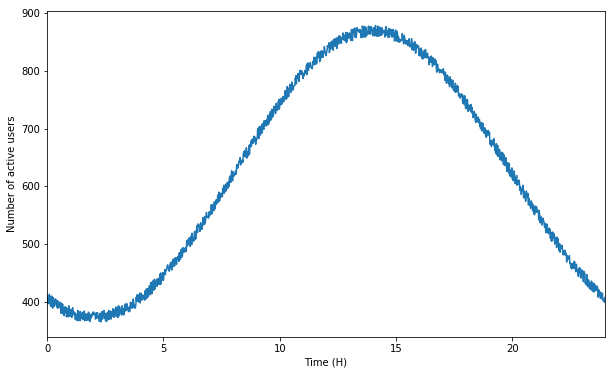

In [4]:
vtU=[]
peak = 900
for ii in range(0,60*24):
    vtU.append(lambdan(ii,peak))
seU=pd.Series(vtU)
seU.index=seU.index/(60)
seU.plot(figsize=(10,6))
plt.xlabel('Time (H)')
plt.ylabel('Number of active users')
plt.show()

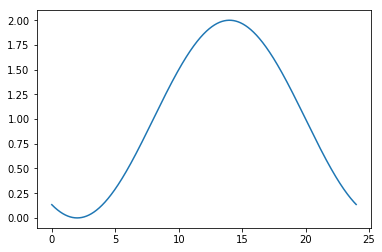

In [5]:
t = np.arange(24*60)
plt.plot(t/60,1+np.sin(2*np.pi*(960+t)/1440))
plt.show()

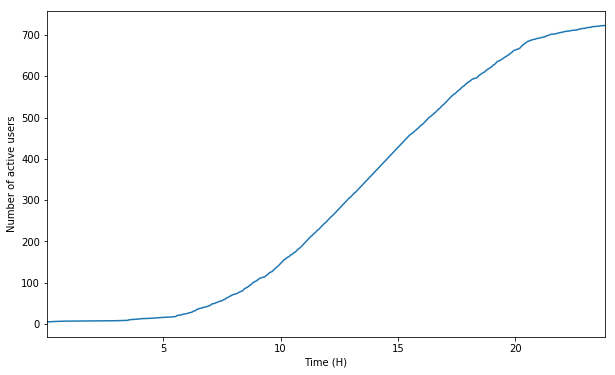

In [73]:
users = []
ii = []
user=5
for i in range(24*60):
    if np.random.uniform(low=0,high=2) <= 1+np.sin(2*np.pi*(960+i)/1440):
        users = np.append(users,user)
        ii.append(i)
        user = user+1
df = pd.Series(data = users,index=ii)
df.index = df.index/60
df.plot(figsize=(10,6))
plt.xlabel('Time (H)')
plt.ylabel('Number of active users')
plt.show()

Usuário conectar:
np.random.